Source: https://stats.stackexchange.com/questions/72774/numerical-example-to-understand-expectation-maximization Suppose we have two groups - red and blue. Specifically, each group contains a value drawn from a normal distribution with the following parameters:

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from collections import namedtuple, Counter

np.random.seed(110) # for reproducible random results

C:\Users\risto\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\risto\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\risto\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


## More automatic example

## Helpers EM

In [2]:
def estimate_initial_params(data, n_clusters):
    means = np.random.choice(data, size=n_clusters, replace=False)
    stds = np.array([0.1 for i in range(n_clusters)])
    return means, stds

In [3]:
def calculate_likelihood(data, class_means, class_stds):
    likelihoods = np.array([stats.norm(mean, std).pdf(data) for mean, std in zip(class_means, class_stds)])
    likelihoods_sum = likelihoods.sum(axis=0)
    classes_weights = likelihoods/likelihoods_sum
    
    return classes_weights.T
    

In [50]:
def estimate_mean(data, weight):
    return np.sum(data * weight) / np.sum(weight)

def estimate_std(data, weight, mean):
    variance = np.sum(weight * (data - mean)**2) / np.sum(weight)
    return np.sqrt(variance)

In [51]:
def estimate_means_stds(data, weights):
    means = [estimate_mean(data, weight) for weight in weights]
    stds = [estimate_std(data, weight, mean) for weight, mean in zip(weights, means)]
    return means, stds

In [52]:
def em(data, n_clusters, n_iters=50):
    means, stds = estimate_initial_params(data, n_clusters)
    
    for i in range(n_iters):
        class_weights = calculate_likelihood(data, means, stds) 
        means, stds = estimate_means_stds(data, class_weights.T)
        
    return means, stds, class_weights

#### run example

In [53]:
df = pd.read_csv('clusters.csv')
df.columns = ['id', 'data']
df.shape

(999, 2)

In [54]:
means, stds, class_weigths = em(df.data, 3, n_iters=1)

In [24]:
def plot_data_results(df_data, means, stds):
    ax=df_data.hist(bins=20, density=True)
    x = np.arange(df_data.min(),df_data.max(), 0.001)
    
    for i in range(len(means)):
        plt.plot(x, stats.norm.pdf(x, means[i], stds[i]), color='red')


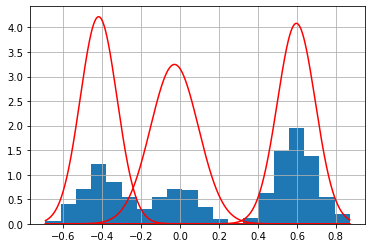

In [25]:
plot_data_results(df.data, means, stds)

In [26]:
class_id = class_weigths.argmax(axis=1)

In [27]:
def plot_clusters(data, class_weights=None, assignments=None):
    if class_weights is not None:
        assignments = class_weigths.argmax(axis=1)
    gby = pd.DataFrame({
            'data': data, 
            'assignment': assignments}
        ).groupby(by='assignment')['data']
    hist_data = [gby.get_group(cid).tolist() 
                 for cid in gby.groups.keys()]
    plt.hist(hist_data, 
             bins=20,
             histtype='stepfilled', alpha=.2 )

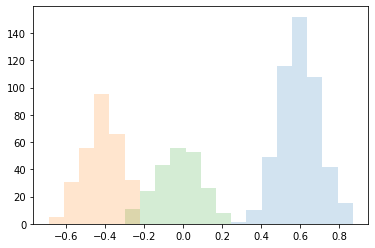

In [28]:
#nicely separated
plot_clusters(df.data, class_weigths)

## Gibbs sampling

### helpers

In [14]:
SuffStat = namedtuple('SuffStat', 'theta N')

def update_suffstats(data, assignments):
    assignments = np.array(assignments)
    suffstats = []
    for cluster_idx in list(set(assignments)):
        cluster_data_idx = assignments==cluster_idx
        mean = data[cluster_data_idx].mean()
        N = cluster_data_idx.sum()
        
        suffstats.append(SuffStat(mean, N))
    return suffstats

In [15]:
def log_assignment_score(data_point, cluster_mean, cluster_variance, pi_cluster):
    """log p(z_i=k \,|\, \cdot) 
    
    We compute these scores in log space for numerical stability.
    """
    x = data_point
    theta = cluster_mean
    var = cluster_variance
    log_pi = np.log(pi_cluster)
    return log_pi + stats.norm.logpdf(x, theta, var)


def assigment_probs(data_point, cluster_ids, cluster_means, cluster_variance, pi):
    """p(z_i=cid \,|\, \cdot) for cid in cluster_ids
    """
    scores = [log_assignment_score(data_point, cluster_means[cid], cluster_variance, pi[cid]) 
              for cid in cluster_ids]

    scores = np.exp(np.array(scores))
    return scores / scores.sum()


def sample_assignment(data_point, cluster_ids, cluster_means, cluster_variance, pi):
    """Sample cluster assignment for data_id given current state
    
    cf Step 1 of Algorithm 2.1 in Sudderth 2006 http://cs.brown.edu/~sudderth/papers/sudderthPhD.pdf
    """
    try:
        p = assigment_probs(data_point, cluster_ids, cluster_means, cluster_variance, pi)
        return np.random.choice(cluster_ids, p=p)
    except:
        #hack, sometimes all p-s are zero, then return cluster 0
        return 0


def update_assignment(data, cluster_ids, cluster_means, cluster_variance, pi, assignments):
    """Update cluster assignment for each data point given current state 
    
    cf Step 1 of Algorithm 2.1 in Sudderth 2006
    """
    for data_id, data_point in enumerate(data):
        assignments[data_id] = sample_assignment(data_point, cluster_ids, cluster_means, cluster_variance, pi)
    suffstats = update_suffstats(data, assignments)
    return assignments, suffstats

In [16]:
def sample_mixture_weights(alpha, num_clusters, cluster_ids, suffstats):
    """Sample new mixture weights from current state according to 
    a Dirichlet distribution 
    
    cf Step 2 of Algorithm 2.1 in Sudderth 2006
    """
    ss = suffstats
    alpha = [ss[cid].N + alpha / num_clusters
             for cid in cluster_ids]
    return stats.dirichlet(alpha).rvs(size=1).flatten()

def update_mixture_weights(alpha, num_clusters, cluster_ids, suffstats, pi):
    """Update state with new mixture weights from current state
    sampled according to a Dirichlet distribution 
    
    cf Step 2 of Algorithm 2.1 in Sudderth 2006
    """
    pi = sample_mixture_weights(alpha, num_clusters, cluster_ids, suffstats)
    return pi

In [17]:
def sample_cluster_mean(cluster_var, hp_mean, hp_var, suffstats_cluster):
    #https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf 2.3
    ss = suffstats_cluster
    numerator = hp_mean / hp_var + ss.theta * ss.N / cluster_var
    denominator = (1.0 / hp_var + ss.N / cluster_var)
    posterior_mu = numerator / denominator
    posterior_var = 1.0 / denominator
    
    return stats.norm(posterior_mu, np.sqrt(posterior_var)).rvs()

def update_cluster_means(cluster_ids, cluster_variance, hp_mean, hp_var, suffstats):
    cluster_means = [sample_cluster_mean(cluster_variance, hp_mean, hp_var, suffstats[cid])
                              for cid in cluster_ids]
    return cluster_means

In [18]:
def gibbs(data, num_clusters, num_steps=5, cluster_variance=0.1, alpha=1.0, hp_mean=0, hp_var=1):
    
    #init variables
    cluster_ids = range(num_clusters)
    assignments = [np.random.choice(cluster_ids) for _ in data]
    pi = [alpha / num_clusters for _ in cluster_ids]
    cluster_means = np.random.choice(data, size = num_clusters, replace=False)
    suffstats = update_suffstats(data, assignments)
    
    for i in range(num_steps):
        assignments, suffstats = update_assignment(data, cluster_ids, cluster_means, cluster_variance, pi, assignments)
        pi = update_mixture_weights(alpha, num_clusters, cluster_ids, suffstats, pi)
        cluster_means = update_cluster_means(cluster_ids, cluster_variance, hp_mean, hp_var, suffstats)
    return assignments, cluster_means, pi

## Run experiment

In [19]:
assignments, cluster_means, pi = gibbs(df.data, 3, num_steps=20)

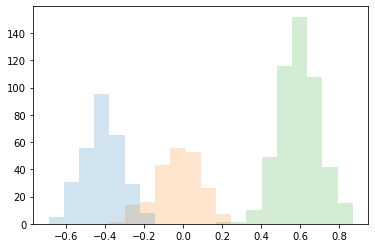

In [20]:
plot_clusters(df.data, class_weights=None, assignments=assignments)